# Benchmark Dataset: Baltimore
This is the google colab to used the trained baseline model to verify on the benchmark dataset to make sure the accuracy

## 1.0 IMPORT LIBRARIES

In [1]:
!pip install transformers
import transformers
import torch
import copy
import numpy as np
import requests
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn, optim
from torch.utils import data
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

     |████████████████████████████████| 1.3MB 11.8MB/s 
     |████████████████████████████████| 890kB 47.0MB/s 
     |████████████████████████████████| 1.1MB 47.4MB/s 
     |████████████████████████████████| 2.9MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4246f50f26c63302ee1fe78f4476fcc00a81e3c2b3c497a94798a710808f8703
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# SETTING
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8,6

moods_code = [["fear", 0], ["anger", 1], ["sadness", 2], ["joy", 3], ["anticipation", 4], ["trust", 5], ["disgust", 6], ["surprise", 7]]
moods = ['fear', 'anger', 'sadness', 'joy', 'anticipation', 'trust', 'disgust', 'surprise']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 2.0 DOWNLOAD AND LOAD DATASET
This step will load the individual benchmark dataset to ve verified by trained model

In [3]:
def compare_str(ori_str, to_str, to_code):
    if ori_str == to_str:
        return str(to_code)
    return ori_str

def convert_mood_class(idf):
    # CONVERT MOOD TO CODE
    for mood_itm in moods_code:
        idf["sentiment"] = idf["sentiment"].apply(lambda x: compare_str(str(x), mood_itm[0], mood_itm[1]))

    idf = idf.astype({"sentiment": int})
    return idf

#BASELINE DATASET
!gdown --id 1sWfZXJwzn-Vzmktk-KSXog6fWdrTpktu
df = pd.read_csv("03-post-spelling-dataset.csv", sep=",")
print(len(df))

df = df[df['tweet_text'].notna()]
df["sentiment"] = 0
print(len(df))

Downloading...
From: https://drive.google.com/uc?id=1sWfZXJwzn-Vzmktk-KSXog6fWdrTpktu
To: /content/03-post-spelling-dataset.csv
6.80MB [00:00, 41.6MB/s]
36677
36655


In [4]:
# LOAD TOKENIZER
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### b. Understand the token lenght distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


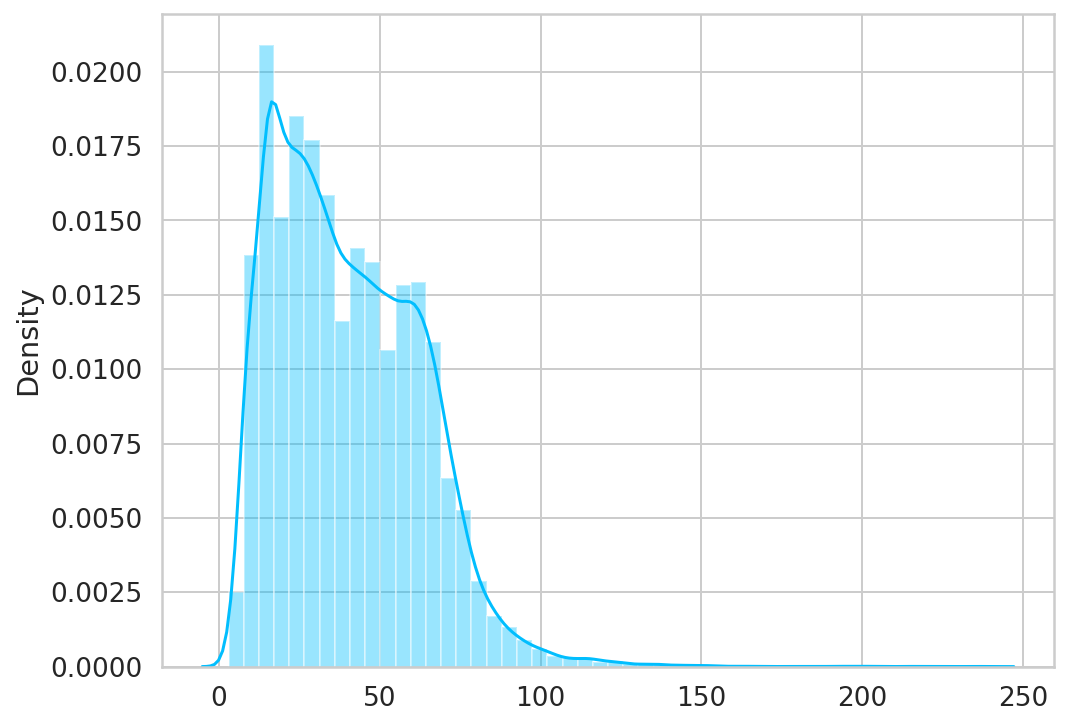

In [5]:
token_lens = []

for txt in df.tweet_text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.savefig("tweet_token_count.png".lower())

## 4.0 CONVERT DATASET TO BERT MODEL

In [6]:
class TweetTextDataset(Dataset):
    def __init__(self, tweet_texts, targets, tokenizer, max_len):
        self.tweet_texts = tweet_texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet_texts)

    def __getitem__(self, item):
        tweet_text = str(self.tweet_texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet_text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': tweet_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [7]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetTextDataset(
        tweet_texts=df.tweet_text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [8]:
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [9]:
test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [10]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)


In [11]:
!gdown --id 1fmNv7ObkcXkKPTIgxD_lrRN3H45zl3ed

Downloading...
From: https://drive.google.com/uc?id=1fmNv7ObkcXkKPTIgxD_lrRN3H45zl3ed
To: /content/best_model_state.bin
433MB [00:01, 259MB/s]


In [12]:
model = SentimentClassifier(len(moods))
model.load_state_dict(torch.load("best_model_state.bin", map_location=torch.device('cpu')))
model = model.to(device)

## 6.0 Bench dataset classification

In [13]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [14]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [23]:
df["sentiment"] = y_pred.data
print(df.head(10))

              tweet_id     tweet_created_dt  ...  sentiment  predicted
0  1245161385392320515  2020-04-01 01:29:42  ...          5          5
1  1245202864001167360  2020-04-01 04:14:32  ...          4          4
2  1246215168180269056  2020-04-03 23:17:04  ...          0          0
3  1246318483765374976  2020-04-04 06:07:36  ...          0          0
4  1246393578710093830  2020-04-04 11:06:00  ...          4          4
5  1246460872958054403  2020-04-04 15:33:24  ...          4          4
6  1246821444908179458  2020-04-05 15:26:11  ...          4          4
7  1247348164249751553  2020-04-07 02:19:11  ...          5          5
8  1247612766745174016  2020-04-07 19:50:37  ...          4          4
9  1247775086599262210  2020-04-08 06:35:37  ...          5          5

[10 rows x 7 columns]


In [33]:
def compare_mood_code(ori_code, mood_str, mood_code):
    
    if str(ori_code) == str(mood_code):
      print(f'ori_code: {ori_code} | mood_code: {mood_code}')
      return mood_str
    return ori_code

for mood_itm in moods_code:
  df["sentiment"] = df["sentiment"].apply(lambda x: compare_mood_code(str(x), mood_itm[0], mood_itm[1]))

moods_code = [["fear", 0], ["anger", 1], ["sadness", 2], ["joy", 3], ["anticipation", 4], ["trust", 5], ["disgust", 6], ["surprise", 7]]
print(df)

df.to_csv('classified_dataset.csv', index=False)

                  tweet_id     tweet_created_dt  ...     sentiment  predicted
0      1245161385392320515  2020-04-01 01:29:42  ...         trust          5
1      1245202864001167360  2020-04-01 04:14:32  ...  anticipation          4
2      1246215168180269056  2020-04-03 23:17:04  ...          fear          0
3      1246318483765374976  2020-04-04 06:07:36  ...          fear          0
4      1246393578710093830  2020-04-04 11:06:00  ...  anticipation          4
...                    ...                  ...  ...           ...        ...
36672  1278115472223895552  2020-06-30 23:57:29  ...  anticipation          4
36673  1278115846703976450  2020-06-30 23:58:58  ...         trust          5
36674  1278115866815737857  2020-06-30 23:59:03  ...         trust          5
36675  1278115905218777089  2020-06-30 23:59:12  ...           joy          3
36676  1278116064686149632  2020-06-30 23:59:50  ...          fear          0

[36655 rows x 7 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


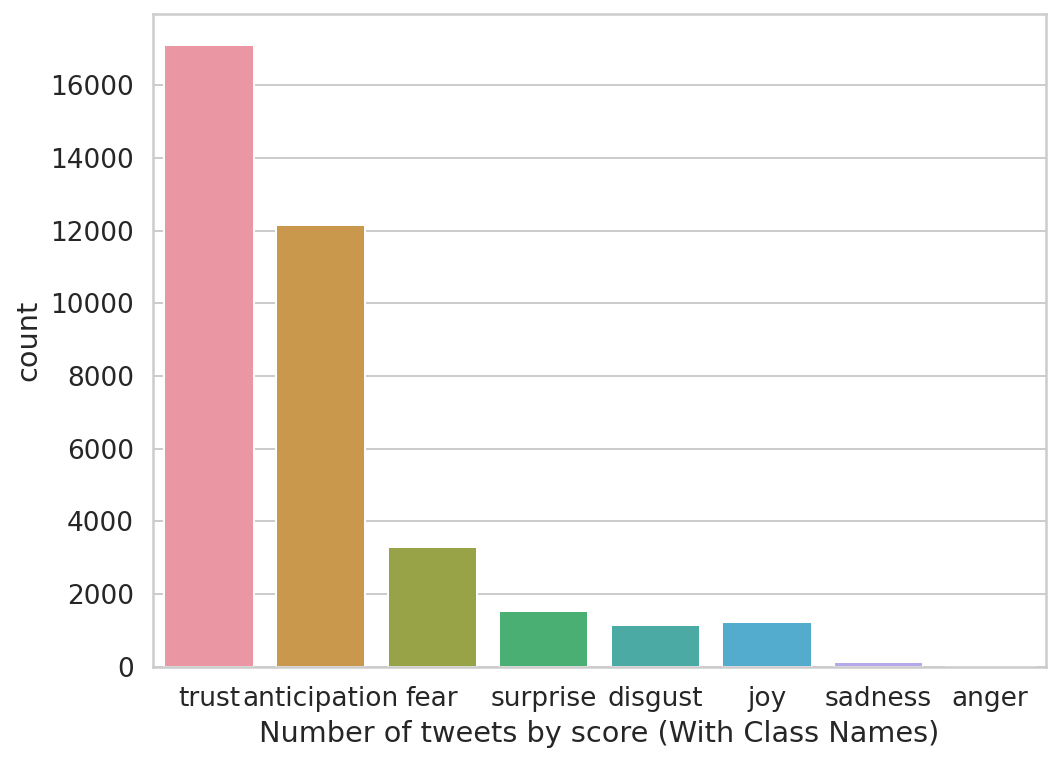

In [31]:
sns.countplot(df.sentiment)
plt.xlabel("Number of tweets by score (With Class Names)")
plt.savefig("predicted_classname_tweet_count.png".lower())